# Self-Driving Car Engineer Nanodegree


## Project - 1: **Finding Lane Lines on the Road** 
***
This project is to identify lane lines on the road. We will develop pipeline of software to identify lane lines on a series of individual images, and later apply the result to a video streams.

The result should roughly looks like "raw-lines-example.mp4". Then we will try to average and/or extrapolate the line segments detected to map out the full extent of the lane lines. Ultimately, we would like to draw just one line for the left side of the lane, and one for the right.

---

**The tools we are going to use are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. The goal is that the pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The final goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import All Necessary Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
%matplotlib inline

ImportError: dlopen(/Users/kkbodke/miniconda3/envs/sdc-p1/lib/python3.6/site-packages/cv2.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libfreetype.6.dylib
  Referenced from: /Users/kkbodke/miniconda3/envs/sdc-p1/lib/libopencv_freetype.3.3.dylib
  Reason: Incompatible library version: libopencv_freetype.3.3.dylib requires version 19.0.0 or later, but libfreetype.6.dylib provides version 18.0.0

## Read all the Images

In [2]:
#Reading in an image
    
def display_images(images, cmap=None):
    columns = 2
    rows = (len(images)+1)
    
    plt.figure(figsize=(15, 20))
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        #cmap = 'Greys_r'
        plt.imshow(image, cmap = cmap)              

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

all_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]

display_images(all_images)


NameError: name 'glob' is not defined

## Step 1: Convert all the original Images into Gray Scale Images


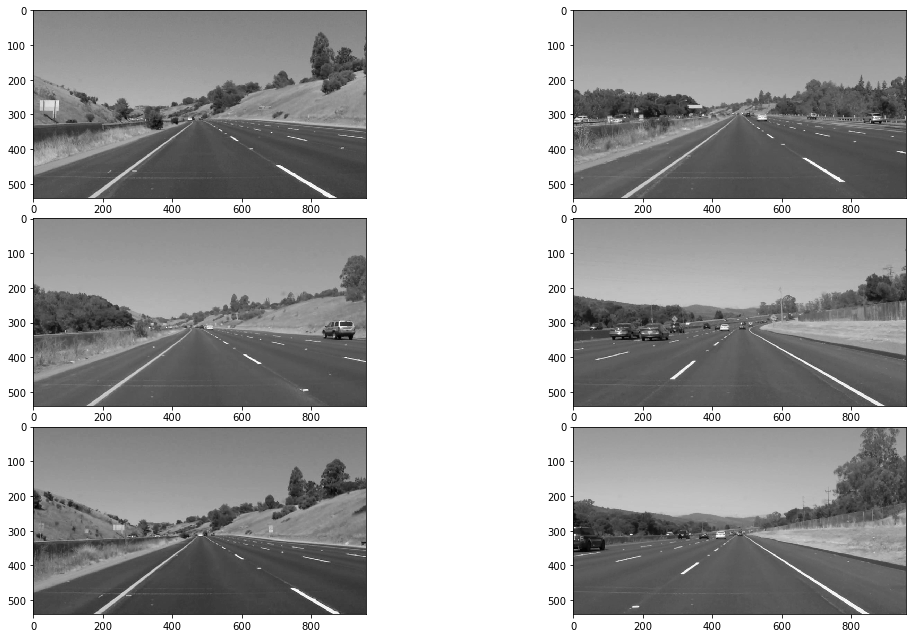

In [3]:
# convert the image to grayscale

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, all_images))
display_images(gray_images, 'Greys_r')

## Step 2: Apply Gaussian smoothing to Grayscale Images to suppress the noise


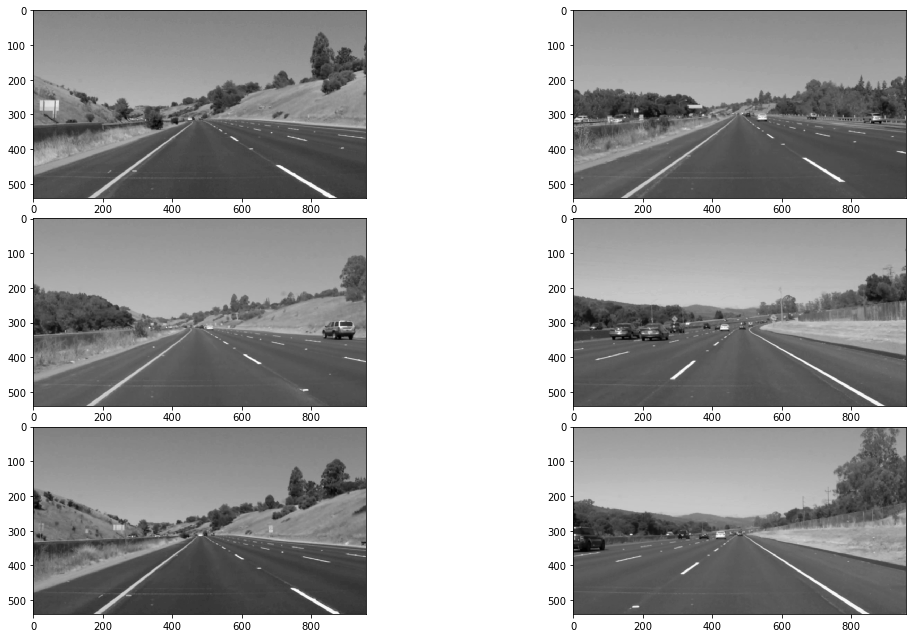

In [4]:
def apply_gaussian(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

smooth_images = list(map(lambda image: apply_gaussian(image), gray_images))

display_images(smooth_images)

## Step 3: Apply Canny Edge Algorithm to detect the edges


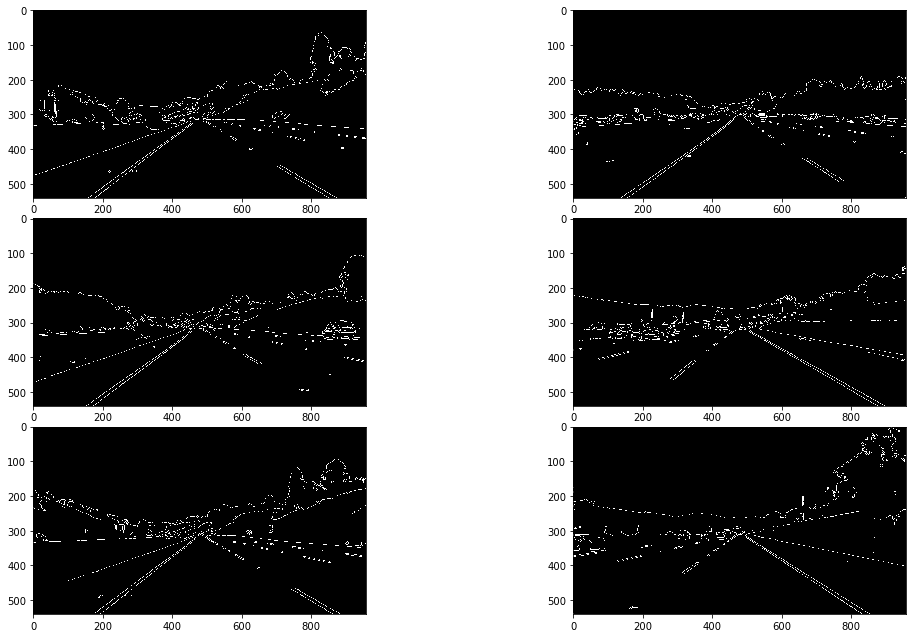

In [5]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

canny_edge_images = list(map(lambda image: detect_edges(image), smooth_images))

display_images(canny_edge_images)

## Step 4: Filter detected edges and select Region of Interest


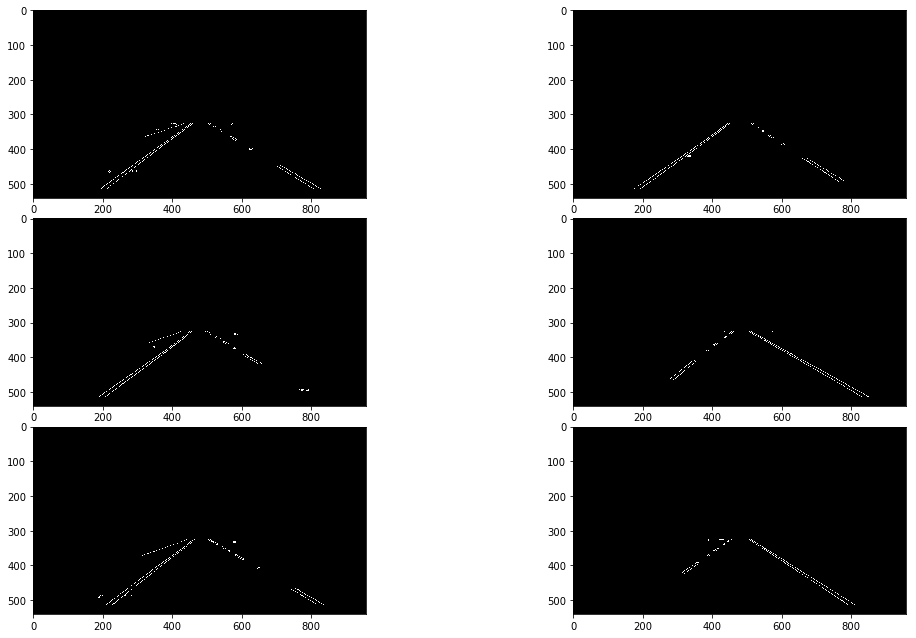

In [8]:
# Apply Region of interest

def filter_region(image):
    rows, columns = image.shape[:2]
    bottom_left  = [columns*0.1, rows*0.95]
    top_left     = [columns*0.4, rows*0.6]
    bottom_right = [columns*0.9, rows*0.95]
    top_right    = [columns*0.6, rows*0.6]
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    mask = np.zeros_like(image)
    ignore_mask_color = 255
    imshape = image.shape
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return cv2.bitwise_and(image, mask)
   

roi_images = list(map(filter_region, canny_edge_images))

display_images(roi_images)


## Step 5: Apply Hough Transformation


In [9]:
# Apply Hough transformation

def hough_transform(image):
    # Make a blank the same size as our image to draw on

    rho = 1 # distance resolution in pixels of the Hough grid

    theta = np.pi/180 # angular resolution in radians of the Hough grid

    threshold = 70    # minimum number of votes (intersections in Hough grid cell)

    min_line_length = 70 #minimum number of pixels making up a line

    max_line_gap = 25   # maximum gap in pixels between connectable line segments

    line_image = np.copy(image)*0 # creating a blank to draw lines on


    # Run Hough on edge detected image

    # Output "lines" is an array containing endpoints of detected line segments

    #return cv2.HoughLinesP(image, rho, theta, threshold, min_line_length, max_line_gap)

    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

hough_lines = list(map(hough_transform, roi_images))

## Step 6: Draw Lines on a Blank Image


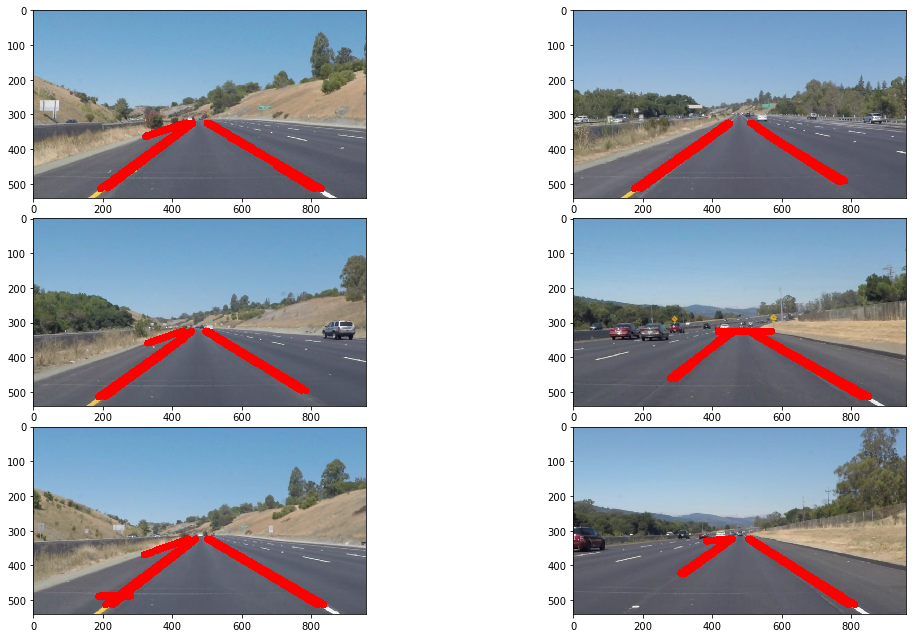

In [10]:
def draw_lines(image, lines, make_copy=True):   
    if make_copy:
        image = np.copy(image) # don't modify the original image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (255,0,0), 20)
    return image


line_images = []
for image, lines in zip(all_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
display_images(line_images)

## Step 7: Averaging and Extrapolating Lines

There are multiple lines detected for a lane line. We should come up with an averaged line for that.

Also, some lane lines are only partially recognized. We should extrapolate the line to cover full lane line length.

We want two lane lines: one for the left and the other for the right. The left lane should have a positive slope, and the right lane should have a negative slope. Therefore, we'll collect positive slope lines and negative slope lines separately and take averages.

Note: in the image, y coordinate is reversed. The higher y value is actually lower in the image. Therefore, the slope is negative for the left lane, and the slope is positive for the right lane.


In [39]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane 

In [40]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

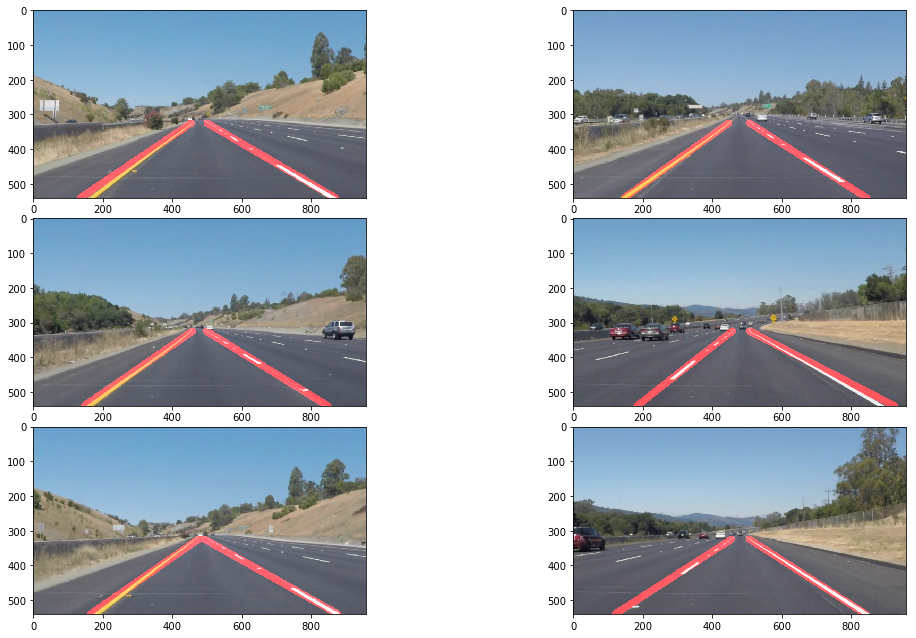

In [41]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(all_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
display_images(lane_images)

## Step 8: Apply all the above steps to a Video Clip


In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)


QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)
               

    def process(self, image):
        
        gray         = convert_gray_scale(image)
        smooth_gray  = apply_gaussian(gray)
        edges        = detect_edges(smooth_gray)
        regions      = filter_region(edges)
        lines        = hough_transform(regions)
        left_line, right_line = lane_lines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        
        right_line = mean_line(right_line, self.right_lines)
        
        return draw_lane_lines(image, (left_line, right_line))


In [46]:
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [50]:
%time process_video('solidWhiteRight.mp4', 'output_white.mp4')
%time process_video('challenge.mp4', 'output_challenge.mp4')
%time process_video('solidYellowLeft.mp4', 'output_yellow.mp4')

[MoviePy] >>>> Building video output_videos/output_white.mp4
[MoviePy] Writing video output_videos/output_white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 20.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_white.mp4 

CPU times: user 2min 29s, sys: 4.59 s, total: 2min 34s
Wall time: 9.03 s
[MoviePy] >>>> Building video output_videos/output_challenge.mp4
[MoviePy] Writing video output_videos/output_challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 14.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_challenge.mp4 

CPU times: user 5min 18s, sys: 10.4 s, total: 5min 28s
Wall time: 19.2 s
[MoviePy] >>>> Building video output_videos/output_yellow.mp4
[MoviePy] Writing video output_videos/output_yellow.mp4


100%|█████████▉| 681/682 [00:30<00:00, 14.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_yellow.mp4 

CPU times: user 9min, sys: 16 s, total: 9min 16s
Wall time: 31 s
